# 1.3 Linear Regression

<a target="_blank" href="https://colab.research.google.com/github/SaajanM/mat422-homework/blob/main/1.3%20Linear%20Regression/linear_regression.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

In [ ]:
# Install a numpy package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib

In [3]:
# Import the numpy package
import numpy as np
import matplotlib
import matplotlib.pyplot as pyplt
from mpl_toolkits.mplot3d import Axes3D
import math

$\newcommand\norm[1]{\left\lVert#1\right\rVert}$

This section covers the basics of linear regression

## Section 1.3.0 Linear Regression Intro

One of the most fundamental tools in a data scientists toolkit is linear regression. It is a remarkably simple method used to linearly approximate correlated data sets. Although it does not work for all data sets, it gives an intuitive starting point for more advanced forms of regression.

## Section 1.3.1 QR Decomposition

QR Decomposition is a useful procedure to solve the linear least squares problem. To obtain a QR Decomposition of a matrix $A$ with linearly independent columns, we first treat $A$'s columns as the input to Gram-Schmidt. We obtain a new matrix $Q$, where the columns of $Q$ correspond to the orthonormal basis vectors comprising of the algorithms output. Additional output of the algorithm is the upper triangular matrix $R$ that contains the coefficients for the each column of $A$ to be represented by a linear combination of the columns of $Q$.

This yields the decomposition $$A=QR$$

As the Gram Schmidt algorithm was already implemented in [homework 1.2](../1.2%20Elements%20of%20Linear%20Algebra/elements_of_linear_algebra.ipynb), we shall instead use the built in ability of `numpy` to accomplish the QR decomposition.

In [22]:
A = np.array([[1, -1, 4], [1, 4, -2], [1, 4, 2], [1, -1, 0]])
print("A:\n{}".format(A))
qr = np.linalg.qr(A)
print("Q:\n{}".format(qr.Q))
print("R:\n{}".format(qr.R))

verify = np.matmul(qr.Q, qr.R)
print("QR:\n{}".format(verify))
print(
    "Approximately A within floating point tolerance?: {}".format(
        np.allclose(verify, A)
    )
)

A:
[[ 1 -1  4]
 [ 1  4 -2]
 [ 1  4  2]
 [ 1 -1  0]]
Q:
[[-0.5  0.5 -0.5]
 [-0.5 -0.5  0.5]
 [-0.5 -0.5 -0.5]
 [-0.5  0.5  0.5]]
R:
[[-2. -3. -2.]
 [ 0. -5.  2.]
 [ 0.  0. -4.]]
QR:
[[ 1.0000000e+00 -1.0000000e+00  4.0000000e+00]
 [ 1.0000000e+00  4.0000000e+00 -2.0000000e+00]
 [ 1.0000000e+00  4.0000000e+00  2.0000000e+00]
 [ 1.0000000e+00 -1.0000000e+00 -4.4408921e-16]]
Approximately A within floating point tolerance?: True


## Section 1.3.2 Least Squares

Let $A\in\mathbb{R}^{n\times m}$ be an $n\times m$ matrix and $\mathbf{b}\in\mathbb{R}^n$ be a vector. The least squares problem is the problem of approximating $\mathbf{b}$ via some $\mathbf{x}\in\mathbf{m}$ such that $A\mathbf{x}\approx\mathbf{b}$

It is reasonable to assume to assume that $A$ has linearly independent columns, as if it doesnt, we can solve a reduced form of $A$ and obtain the same solution. If $n=m$ then we can simply take the matrix inverse to solve the solution. But if $n>m$ (overdetermined), we cannot take an inverse. Instead we view the problem as the **least squares problem**:
$$\min_{\mathbf{x}\in\mathbb{R}^{m}}\norm{A\mathbf{x}-\mathbf{b}}$$

We begin by projecting $\mathbf{b}$ onto the column space of $A$. One might be tempted to use the algorithm presented in the Best Approximation Theorem, however it yields significant numerical issues when applied to computational tasks.

Instead we can find the QR Decomposition of $A$ and then find the projection matrix $\mathscr{P}_{\text{col}(A)} = QQ^T$. We then apply the projection to $\mathbf{b}$ to obtain $\mathbf{b}^\ast=QQ^T\mathbf{b}$.

This guarantees the ability to solve the equation $A\mathbf{x}^\ast=QQ^T\mathbf{b}$, where $\mathbf{x}^\ast$ is the least squares solution.

But, we already know $A=QR$, so we can rewrite this as $QR\mathbf{x}^\ast=QQ^T\mathbf{b}$.

The $Q$'s can then "cancel" by multiplying by $Q^T$ on the left (because $Q^TQ=I_{m\times m}$)

This leaves us with $R\mathbf{x}^\ast=Q^T\mathbf{b}$

Because $R$ is upper triangular, solving is extremely straightforward. It can be done with back-substitution.

An example implementation is shown below along with `numpy`'s built in solution.

In [51]:
def lst_sq(A, b):
    qr = numpy.linalg.qr(A)
    # The @ symbol is shorthand for np.matmul
    b_approx = np.transpose(qr.Q) @ b
    R = qr.R
    size = R.shape[0]
    x = np.zeros(size)
    for i in range(1, size + 1):
        b_i = b_approx[size - i]
        R_ii = R[size - i, size - i]
        prev = 0
        for j in range(1, i):
            prev += R[size - i, size - j] * x[size - j]
        x_i = (b_i - prev) / R_ii
        x[size - i] = x_i
    return x


A = np.array([[3, -6], [4, -8], [0, 1]])
b = np.array([-1, 7, 2])
print("Approximating x for Ax=b where A=\n{}\nand b=\n{}".format(A, b))
custom_implementation = lst_sq(A, b)
numpy_implementation = np.linalg.lstsq(A, b, rcond=None)[0]
print("My Implementation:\tx = {}".format(custom_implementation))
print("Numpy Implementation:\tx = {}".format(numpy_implementation))
print(
    "Are they the same?: {}".format(
        "Yes" if np.allclose(custom_implementation, numpy_implementation) else "No"
    )
)

Approximating x for Ax=b where A=
[[ 3 -6]
 [ 4 -8]
 [ 0  1]]
and b=
[-1  7  2]
My Implementation:	x = [5. 2.]
Numpy Implementation:	x = [5. 2.]
Are they the same?: Yes


## Section 1.3.3 Linear Regression

Given input data points $\left\{(\mathbf{x}_i,y_i)\right\}_{i=1}^{n}$ with each $\mathbf{x}_i=(x_{i1},\dots,x_{id})^T$, we seek an affine function to fit the data.

We can do so by finding coefficients $\beta_j$ that minimize the sum of errors between the predicted and actual "$y$" values ($y$ is a function of $x$ in this case).

This can be described by the matrix equation $A\mathbf{\beta}\approx\mathbf{y}$ where $\mathbf{y}$ is a column vector of the $y_i$'s, $\mathbf{\beta}$ is a column vector of the coefficients $\beta_j$, and
$$
A=\begin{pmatrix}
1 & \mathbf{x}_1^T\\
1 & \mathbf{x}_2^T\\
\vdots & \vdots\\
1 & \mathbf{x}_n^T\\
\end{pmatrix}
$$

This is just the least squares problem discussed above, as we are attempting to approximate $\mathbf{y}$. So we can directly apply that procedure.

Here is an example using `numpy`'s `np.linalg.lstsq()` function to do least squares and obtain linear regression.

f(x) = 0.5929533625132145 + 1.0711143734023607x


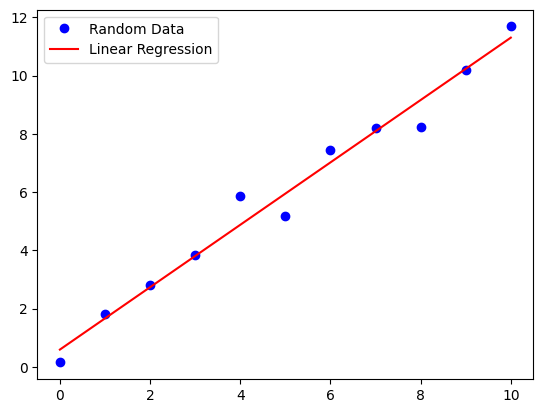

In [70]:
# Data points
x = np.linspace(0, 10, 11)
y = x + 2 * np.random.rand(x.shape[0])

# Graph the data points
fig = pyplt.figure()

ax = fig.add_subplot()

ax.plot(x, y, "ob", label="Random Data")

# Do linear regression
ones = np.ones((1, x.shape[0])).T
vx = np.atleast_2d(x).T
A = np.hstack((ones, vx))
soln = np.linalg.lstsq(A, y, rcond=None)[0]

print("f(x) = {} + {}x".format(soln[0], soln[1]))

# Graph line
y_approx = soln[0] + soln[1] * x
ax.plot(x, y_approx, "-r", label="Linear Regression")

ax.legend()